## version 2 2022.08.31 update: cleaned up the order 2 classes, added $value, daily pnl
## version 3 2022.09.18 update: handle exception if options expired. need to get one snapshot of delta for ES_SPY and bonds.  estimated delta from port matches daily pnl well for spy

In [78]:
import math
from scipy.stats import norm
import matplotlib.pyplot as plt #before plotting
import numpy as np
import pandas as pd #wes mckinney creation from R dataframes..2000 pages!
from pylab import *

from operator import attrgetter  #helps to split bins for strikes'distances

import blpapi
import datetime as dt
import tia.bbg.datamgr as dm

from tia.bbg import LocalTerminal 

#from VolSurface import VolSurface
from FXOption_v2 import FXOption


from datetime import date

#from datetime import datetime
from dateutil.relativedelta import relativedelta

from pandas.tseries.offsets import BDay #use last BD to bypass feed issues on hols and early mrng

pd.set_option('display.max_rows', 200) #https://stackoverflow.com/questions/16424493/pandas-setting-no-of-max-rows
pd.options.display.max_rows 
#pd.set_option('display.max_columns', 60) #https://stackoverflow.com/questions/16424493/pandas-setting-no-of-max-rows
pd.options.display.max_columns = None

In [79]:
#helper functions
#https://github.com/woutervanheeswijk/Implied_volatility_calculator/blob/main/implied_volatility_calculator.ipynb

def black_scholes_call(S0, K, T, r, v):
    d1 = (log((S0 / K)) + (r + 0.5 * (v ** 2)) * T) / (v * sqrt(T))   
    d2 = (log((S0 / K)) + (r - 0.5 * (v ** 2)) * T) / (v * sqrt(T))
    
    bs_option_price = (S0 * norm.cdf(d1, 0.0, 1.0) - K * exp(-r * T) * norm.cdf(d2, 0.0, 1.0))

    return bs_option_price


def black_scholes_put(S0, K, T, r, v):
    d1 = (log((S0 / K)) + (r + 0.5 * (v ** 2)) * T) / (v * sqrt(T))   
    d2 = (log((S0 / K)) + (r - 0.5 * (v ** 2)) * T) / (v * sqrt(T))
    #print(d2)
    bs_option_price = (K * exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S0 * norm.cdf(-d1, 0.0, 1.0))
    
    return bs_option_price

def black_scholes_vega(S, K, T, r, v):
    d1 = (log(S / K) + (r + 0.5 * v ** 2) * T) / (v * sqrt(T))
    
    bs_vega = S * norm.pdf(d1) * sqrt(T)
    return bs_vega

"""Implied volatility is found using the Newton-Raphson method"""
def compute_implied_volatility(true_price, S, K, r, T, n, call_put, exercise_policy):
    MAX_NO_ITERATIONS = 100
    MAX_VOL_UPDATE = 0.1
    ACCURACY = 1.0e-5
    
    
    # Check if feasible solution exists (if not, return implied volatility of 0)
    if call_put=='Call' and black_scholes_call(S, K, T, r, 1.0e-5) > true_price:
        print('No feasible solution exists for strike price', K)
        return 1.0e-5
    
    if call_put=='Put' and black_scholes_put(S, K, T, r, 1.0e-5) > true_price:
        print('No feasible solution exists for strike price', K)
        return 1.0e-5
    
    implied_vol = .5 # Initial estimate for implied volatility 
    
    for i in range(MAX_NO_ITERATIONS):
        # Compute price with binomial lattice, using current estimate for implied volatility
        if call_put=='Call':
            model_price = black_scholes_call(S, K, T, r, implied_vol)
        elif call_put=='Put':
            model_price = black_scholes_put(S, K, T, r, implied_vol)
            
        # Compute difference between model price and market price (the root) 
        diff = model_price - true_price

        # Terminate algorithm if desired precision has been hit 
        if (abs(diff) < ACCURACY):
            return implied_vol
        
        # Update implied volatility based on vega and observed error
        vega = black_scholes_vega(S, K, T, r, implied_vol)

        implied_vol -= np.clip(diff/vega, -MAX_VOL_UPDATE, MAX_VOL_UPDATE)
        
    # If maximum number of iterations is hit, simply return best estimate so far
    return implied_vol

In [80]:
start = dt.datetime(2022,5, 20) #bit silly just getting last day, why not get time series  i/o dt.datetime.today() - BDay(1)
end = dt.datetime.today()  #start

def get_market_data(pair, fields, start_date, end_date, period):
    '''imports historical data from bbg api, converts to dataframe '''
    resp = LocalTerminal.get_historical(pair, fields, start_date, end_date, period)
    prices = resp.as_frame()
    #use below to start at second row , to get rid of the extra column index ['XYZ Curncy'] title on top
    prices.columns = prices.columns.get_level_values(1) #layer one
    return prices


FVU2 = get_market_data('FVU2 Comdty', 'PX_LAST', start, end, 'DAILY')
FVZ2 = get_market_data('FVZ2 Comdty', 'PX_LAST', start, end, 'DAILY')
ESU2 = get_market_data('ESU2 Index', 'PX_LAST', start, end, 'DAILY')
ESZ2 = get_market_data('ESZ2 Index', 'PX_LAST', start, end, 'DAILY')
SPY = get_market_data('SPY US Index', 'PX_LAST', start, end, 'DAILY')

In [83]:
index = -1 #if want last value of time series,  0 if there is only one value 

prices_map = {'FVU2': FVU2.iloc[index], 
              'FVZ2' : FVZ2.iloc[index],
             'ESU2': ESU2.iloc[index], 
             'ESZ2': ESZ2.iloc[index],
             'SPY': SPY.iloc[index]}
#later version voesl back out from prices? curerntly FVA1 Comdty OVDV
def spot_assigner(row, dictio, spot_vol):

    #print(row)
    Inst = row['Inst'] #dicitonary key
    
    try:
        if spot_vol == "spot":
            spot = dictio[Inst]['PX_LAST']#.values
            #spot = dictio[Inst][0]
            #print(spot)
            return spot
        else:
            vol = dictio[Inst][1]
            return vol
    except:
        return np.nan
    
prices_map#['ESU2']['PX_LAST']




{'FVU2': PX_LAST    109.359375
 Name: 2022-09-16 00:00:00, dtype: float64,
 'FVZ2': PX_LAST    109.304688
 Name: 2022-09-16 00:00:00, dtype: float64,
 'ESU2': PX_LAST    3871.24
 Name: 2022-09-16 00:00:00, dtype: float64,
 'ESZ2': PX_LAST    3890.0
 Name: 2022-09-16 00:00:00, dtype: float64,
 'SPY': PX_LAST    385.56
 Name: 2022-09-16 00:00:00, dtype: float64}

In [166]:
class Positions(object):
    'displays positions in some underlying'
    def __init__(self):
        self.positions = dict() #map each possy to an instru?
        
    def add_instrument(self, trade_id, inst, expiry, call_put_flag, strike, size, vol, cost):
        #inputs: 'Inst', 'Expiry', 'Call/Put', 'Strike', 'Size', 'Vol', 'Cost'
        self.positions[trade_id] =  (inst, expiry, call_put_flag, strike, size, vol, cost)
        # n return self.positions
    def show_positions(self):
        return self.positions
    
    def _multiplier_(self, inst):
        ''' Eminis multpier 50, bonds 1000, stonks 100 usually '''
        if 'ES' in inst:
            return int(50)
        elif 'FV' in inst:
            return 1000
        elif 'SPY' in inst:
            return 100

    def _distance_(self, call_put_flag, spot, strike):
        '''distance b//n strike and undelrying '''
        if call_put_flag == 'Call':
            return np.log(spot/strike)*100
        return np.log(strike/spot)*100

    def _get_portfolio_(self):
        print(self.positions)
        df_port = pd.DataFrame(self.positions).transpose()

        df_port.columns =  ['Inst', 'Expiry', 'Call/Put', 'Strike', 'Size', 'Vol', 'Cost']
        df_port = df_port.set_index(['Expiry'])
        df_port.index = pd.to_datetime(df_port.index, dayfirst = True)
        today  = pd.datetime.today()
        df_port['Days'] = (df_port.index - today).days
        
        #take current 'spot' from prices_map
        df_port['Spot'] = df_port.apply(spot_assigner, dictio = prices_map, spot_vol = "spot",  axis = 1)
        #calc distance of strikes
        df_port['Distance%'] = df_port.apply(lambda x: self._distance_(x['Call/Put'], x['Spot'], x['Strike']), axis = 1).round(1)
        #apply multiplier to Inst , basically 50 for Es, 1000 for FV, 100 for SPY
        df_port['Multiplier'] = df_port['Inst'].apply(self._multiplier_)
        #apply FXOption to create object and price in BS units    

        df_port['Price'] = df_port.apply(lambda x: 0.0 if x['Days'] < 0 else FXOption(CallPutFlag = x['Call/Put'],
                                                   K = x['Strike'],
                                                  dateEnd = x['Days'],
                                                   notional = 1 ,# x['Size']*x['Strike'],
                                                   premConvention = 'DomesticPips').price(S = x['Spot'],
                                                                             sigma = x['Vol']/100,
                                                                             rFor = 0.02,
                                                                          rDom = 0.025), axis = 1).apply(lambda x: round(x,3))

        df_port['Delta'] = df_port.apply(lambda x: 0.0 if x['Days']<0 else FXOption(CallPutFlag = x['Call/Put'],
                                                               K = x['Strike'],
                                                               dateEnd = x['Days'],
                                                               notional = 1,
                                                               premConvention = '').delta(S = x['Spot'],
                                                                                          sigma = x['Vol']/100,
                                                                                          rFor = 0.02, 
                                                                                          rDom = 0.025, 
                                                                                          convention = 'SEF'), axis = 1)

        df_port['Price$'] = df_port['Price'] * df_port['Multiplier']*df_port['Size']
        #set notional = 1 to see it in % 0 to 100, get sense of moneyness

        df_port['Delta$'] = (df_port['Delta']*df_port['Size']*df_port['Multiplier']*df_port['Strike']).apply(lambda x: round(x,1))
        df_port['MTM'] = df_port['Price$'] - df_port['Cost']*df_port['Multiplier']*df_port['Size']

        return df_port

In [168]:
class OptionTracker(object):
    '''Tracks PnL & implied vols over time period start to expiry for [sec]  '''
    
    def __init__(self, start, expiry, secs, positions, strikes, callput):
        self.start = start
        self.expiry = expiry
        self.secs = secs #list of ssecs
        self.positions = positions # [1, -1, 1]
        self.strikes = strikes
        self.callput  = callput #['Put', 'Call', 'Call']
        
        ''' Eminis multpier 50, bonds 1000, stonks 100 usually '''
        if 'ES' in self.secs[0]:
            self.multiplier = 50
        elif 'FV' in self.secs[0]:
            self.multiplier = 1000
        elif 'SPY' in self.secs[0]:
            self.multiplier = 100
        
        
        
    def create_time_series(self):
        prices =  self.__get_market_data__()
        prices['tau'] = (self.expiry- prices.index).days/365
        
        
        #calcualte implied vols
        for i in range(len(self.positions)):
            
            prices['vol'+str(i+1)] = prices.apply(lambda x: compute_implied_volatility(true_price = x.iloc[i + 1],\
                                                                S = x.iloc[0],\
                                                                K = self.strikes[i],\
                                                                r = 0.02,\
                                                                T = x['tau'], \
                                                                n = 10, \
                                                                call_put = self.callput[i],
                                                                exercise_policy = 'European'), axis = 1)
                                  
        #column 0 is underlying, 1,2,3 are the prices
        prices['sum'] = prices.iloc[:,1]*self.positions[0] +\
                        prices.iloc[:,2]*self.positions[1] +\
                        prices.iloc[:,3]*self.positions[2]
        
        #column 0 is underlying, 1,2,3 are the positions
        prices['sum$'] = prices['sum']*self.multiplier 
        prices['pnl_period'] = prices['sum$'] - prices['sum$'].shift(1)
        
        
        
        return prices
        
    def __get_market_data__(self):  
        '''imports historical data from bbg api, converts to dataframe '''
        resp = LocalTerminal.get_historical(self.secs, 'PX_LAST', self.start, self.expiry, 'DAILY')
        prices = resp.as_frame()
        #layer 0 returns sec name, layer one returns PX_LAST
        prices.columns = prices.columns.get_level_values(0) 
        return prices

In [86]:
from scipy.stats import norm
norm.cdf(0.2,0,1)

0.579259709439103

In [195]:
ES = Positions()  
ES.add_instrument(0,'ESU2', date(2022,9,16), 'Put',  4000, 5, 21,  113.78 )
ES.add_instrument(1,'ESU2', date(2022,9,16), 'Put',  3500, -7, 29,  57.52 )
ES.add_instrument(2,'ESU2', date(2022,9,16), 'Call',  5200, -2, 12,  20.47)
ES.add_instrument(3,'ESU2', date(2022,9,16), 'Call',  5300, -3, 12,  20.22 )

ES.add_instrument(4,'ESZ2', date(2022,12,16), 'Put', 3500, 10, 30, 68.85)#entry 2022.08 early after Powell's pivot that wasn't. Added after NFP but too soon
ES.add_instrument(5,'ESZ2', date(2022,12,16), 'Put', 3000, -10, 30, 24.62)
ES.add_instrument(6,'ESZ2', date(2022,12,16), 'Call', 4550, -10, 17, 44)#covered 4 2022.09.16

print(delta)
ES._get_portfolio_()

{0: ('ESU2', datetime.date(2022, 9, 16), 'Put', 4000, 5, 21, 113.78), 1: ('ESU2', datetime.date(2022, 9, 16), 'Put', 3500, -7, 29, 57.52), 2: ('ESU2', datetime.date(2022, 9, 16), 'Call', 5200, -2, 12, 20.47), 3: ('ESU2', datetime.date(2022, 9, 16), 'Call', 5300, -3, 12, 20.22), 4: ('ESZ2', datetime.date(2022, 12, 16), 'Put', 3500, 10, 30, 68.85), 5: ('ESZ2', datetime.date(2022, 12, 16), 'Put', 3000, -10, 30, 24.62), 6: ('ESZ2', datetime.date(2022, 12, 16), 'Call', 4550, -10, 17, 44)}
0.0341155357944593
Expiry
2022-12-16     2504.5
2022-12-16     8484.5
2022-12-16    19877.5
Name: MTM, dtype: object
{0: ('ESU2', datetime.date(2022, 9, 16), 'Put', 4000, 5, 21, 113.78), 1: ('ESU2', datetime.date(2022, 9, 16), 'Put', 3500, -7, 29, 57.52), 2: ('ESU2', datetime.date(2022, 9, 16), 'Call', 5200, -2, 12, 20.47), 3: ('ESU2', datetime.date(2022, 9, 16), 'Call', 5300, -3, 12, 20.22), 4: ('ESZ2', datetime.date(2022, 12, 16), 'Put', 3500, 10, 30, 68.85), 5: ('ESZ2', datetime.date(2022, 12, 16), 'Put

,Inst,Call/Put,Strike,Size,Vol,Cost,Days,Spot,Distance%,Multiplier,Price,Delta,Price$,Delta$,MTM
Expiry,,,,,,,,,,,,,,,
2022-09-16,ESU2,Put,4000,5,21,113.78,-3,3871.24,3.3,50,0.000,0.000000,0.0,0.0,-28445.0
2022-09-16,ESU2,Put,3500,-7,29,57.52,-3,3871.24,-10.1,50,0.000,0.000000,-0.0,-0.0,20132.0
2022-09-16,ESU2,Call,5200,-2,12,20.47,-3,3871.24,-29.5,50,0.000,0.000000,-0.0,-0.0,2047.0
2022-09-16,ESU2,Call,5300,-3,12,20.22,-3,3871.24,-31.4,50,0.000,0.000000,-0.0,-0.0,3033.0
2022-12-16,ESZ2,Put,3500,10,30,68.85,88,3890.00,-10.6,50,73.859,-0.211116,36929.5,-369452.2,2504.5
2022-12-16,ESZ2,Put,3000,-10,30,24.62,88,3890.00,-26.0,50,7.651,-0.032326,-3825.5,48488.3,8484.5
2022-12-16,ESZ2,Call,4550,-10,17,44,88,3890.00,-15.7,50,4.245,0.034116,-2122.5,-77612.8,19877.5


In [205]:
delta = ES._get_portfolio_().iloc[-3:, -2].sum()
delta

{0: ('ESU2', datetime.date(2022, 9, 16), 'Put', 4000, 5, 21, 113.78), 1: ('ESU2', datetime.date(2022, 9, 16), 'Put', 3500, -7, 29, 57.52), 2: ('ESU2', datetime.date(2022, 9, 16), 'Call', 5200, -2, 12, 20.47), 3: ('ESU2', datetime.date(2022, 9, 16), 'Call', 5300, -3, 12, 20.22), 4: ('ESZ2', datetime.date(2022, 12, 16), 'Put', 3500, 10, 30, 68.85), 5: ('ESZ2', datetime.date(2022, 12, 16), 'Put', 3000, -10, 30, 24.62), 6: ('ESZ2', datetime.date(2022, 12, 16), 'Call', 4550, -10, 17, 44)}
0.0341155357944593


-398576.7

['ES1 Index', 'ESU2P 4000 Index', 'ESU2P 3500 Index', 'ESU2C 5200 Index'] [5, -7, -5] [4000, 3500, 5200] ['Put', 'Put', 'Call']


<ipython-input-79-c500cffa4f2c>:14: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (log((S0 / K)) + (r + 0.5 * (v ** 2)) * T) / (v * sqrt(T))
<ipython-input-79-c500cffa4f2c>:15: RuntimeWarning: divide by zero encountered in double_scalars
  d2 = (log((S0 / K)) + (r - 0.5 * (v ** 2)) * T) / (v * sqrt(T))
<ipython-input-79-c500cffa4f2c>:22: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (log(S / K) + (r + 0.5 * v ** 2) * T) / (v * sqrt(T))
<ipython-input-79-c500cffa4f2c>:62: RuntimeWarning: divide by zero encountered in double_scalars
  implied_vol -= np.clip(diff/vega, -MAX_VOL_UPDATE, MAX_VOL_UPDATE)
<ipython-input-79-c500cffa4f2c>:14: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (log((S0 / K)) + (r + 0.5 * (v ** 2)) * T) / (v * sqrt(T))
<ipython-input-79-c500cffa4f2c>:15: RuntimeWarning: divide by zero encountered in double_scalars
  d2 = (log((S0 / K)) + (r - 0.5 * (v ** 2)) * T) / (v * sqrt(T))
<ipython-input-79-c500cf

,ES1 Index,ESU2P 4000 Index,ESU2P 3500 Index,ESU2C 5200 Index,tau,vol1,vol2,vol3,sum,sum$,pnl_period
date,,,,,,,,,,,
2022-04-04,4577.75,95.25,42.75,16.00,0.452055,0.271641,0.326414,0.127705,97.00,4850.0,NaN
2022-04-05,4520.25,112.00,51.25,13.25,0.449315,0.278457,0.333888,0.132494,135.00,6750.0,1900.0
2022-04-06,4475.75,121.50,55.25,11.00,0.446575,0.278888,0.333906,0.135103,165.75,8287.5,1537.5
2022-04-07,4496.25,116.50,52.50,11.75,0.443836,0.279237,0.333682,0.133965,156.25,7812.5,-475.0
2022-04-08,4483.50,116.25,52.00,10.50,0.441096,0.276563,0.331272,0.133346,164.75,8237.5,425.0
2022-04-11,4409.00,134.00,59.75,8.00,0.432877,0.279041,0.333716,0.139748,211.75,10587.5,2350.0
2022-04-12,4393.00,137.50,61.00,7.75,0.430137,0.279233,0.333641,0.142032,221.75,11087.5,500.0
2022-04-13,4442.25,119.00,52.00,8.50,0.427397,0.273037,0.328160,0.136787,188.50,9425.0,-1662.5
2022-04-14,4387.50,132.00,57.00,6.75,0.424658,0.273383,0.327365,0.140246,227.25,11362.5,1937.5


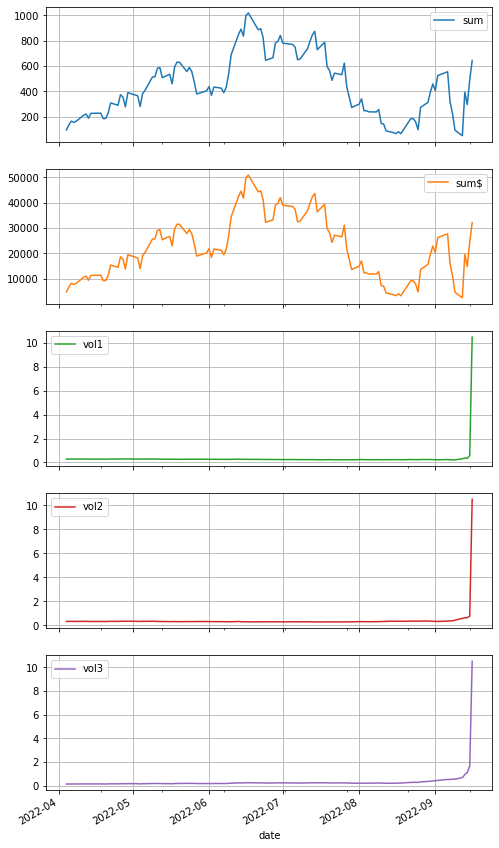

In [198]:
secs = ['ES1 Index','ESU2P 4000 Index','ESU2P 3500 Index','ESU2C 5200 Index']
positions = [5, -7,-5]
strikes = [4000, 3500, 5200]
callput = ['Put','Put', 'Call']

#sanitycheck
print(secs, positions, strikes, callput)
esu = OptionTracker(dt.datetime(2022,4,2), dt.datetime(2022,9,16), secs, positions, strikes, callput)
data_esu = esu.create_time_series()


data_esu[['sum','sum$', 'vol1', 'vol2', 'vol3']].plot(subplots = True, grid = True, figsize = (8,16))
data_esu

,ES1 Index,ESZ2P 3500 Index,ESZ2P 3000 Index,ESZ2C 4550 Index,tau,vol1,vol2,vol3,sum,sum$,pnl_period
date,,,,,,,,,,,
2022-07-28,4073.50,67.00,24.00,43.75,0.386301,0.285446,0.345942,0.176125,-7.5,-375.0,NaN
2022-07-29,4133.50,58.25,21.25,55.25,0.383562,0.287027,0.349119,0.175636,-182.5,-9125.0,-8750.0
2022-08-01,4120.50,63.00,22.75,54.00,0.375342,0.294867,0.355709,0.179905,-137.5,-6875.0,2250.0
2022-08-02,4093.75,68.50,24.75,48.50,0.372603,0.298136,0.358635,0.180800,-47.5,-2375.0,4500.0
2022-08-03,4156.25,56.50,20.25,59.00,0.369863,0.294548,0.355875,0.177232,-227.5,-11375.0,-9000.0
2022-08-04,4152.25,56.25,20.25,58.50,0.367123,0.294137,0.356383,0.178529,-225.0,-11250.0,125.0
2022-08-05,4146.75,55.25,19.50,55.00,0.364384,0.291991,0.353673,0.176334,-192.5,-9625.0,1625.0
2022-08-08,4141.75,56.00,20.00,53.25,0.356164,0.295258,0.358591,0.177701,-172.5,-8625.0,1000.0
2022-08-09,4124.50,57.50,20.50,48.50,0.353425,0.294634,0.358478,0.176998,-115.0,-5750.0,2875.0


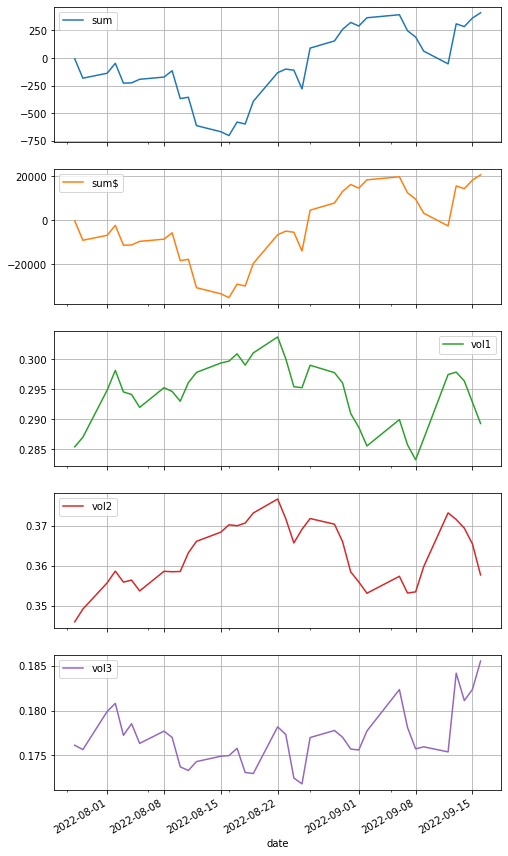

In [171]:
secs = ['ES1 Index','ESZ2P 3500 Index','ESZ2P 3000 Index','ESZ2C 4550 Index']
positions = [10,-10,-10]
strikes = [3500, 3000, 4550]
callput = ['Put','Put', 'Call']
esz = OptionTracker(dt.datetime(2022,7,28), dt.datetime(2022,12,16), secs, positions,strikes, callput)
data_esz = esz.create_time_series()

#graph_prices =  data[data['sum']*14*1000).plot()
data_esz[['sum', 'sum$','vol1', 'vol2', 'vol3']].plot(subplots = True, grid = True, figsize = (8,16))
data_esz

In [172]:
SPY = Positions()  
SPY.add_instrument(0,'SPY', date(2022,12,16), 'Put', 377, 10, 26.42, 8.84 )#entry 2022.08.10 check vols.add_instrument(1,'FVU2', date(2022,8,23), 'Call', 115.5, -14, 4.5,0.61 )
SPY.add_instrument(1,'SPY', date(2022,12,16), 'Put', 340, -10, 31, 3.97) #entry 2022.08.10 chekc vols)
SPY.add_instrument(2,'SPY', date(2022,12,16), 'Call', 458, -10, 18.27, 5.27)

SPY._get_portfolio_()
            

{0: ('SPY', datetime.date(2022, 12, 16), 'Put', 377, 10, 26.42, 8.84), 1: ('SPY', datetime.date(2022, 12, 16), 'Put', 340, -10, 31, 3.97), 2: ('SPY', datetime.date(2022, 12, 16), 'Call', 458, -10, 18.27, 5.27)}
0.031224552137900183


,Inst,Call/Put,Strike,Size,Vol,Cost,Days,Spot,Distance%,Multiplier,Price,Delta,Price$,Delta$,MTM
Expiry,,,,,,,,,,,,,,,
2022-12-16,SPY,Put,377,10,26.42,8.84,88,385.56,-2.2,100,15.451,-0.400432,15451.0,-150962.7,6611.0
2022-12-16,SPY,Put,340,-10,31,3.97,88,385.56,-12.6,100,6.192,-0.180494,-6192.0,61367.9,-2222.0
2022-12-16,SPY,Call,458,-10,18.27,5.27,88,385.56,-17.2,100,0.408,0.031225,-408.0,-14300.8,4862.0


In [191]:
delta = SPY._get_portfolio_().iloc[-3:,-2].sum()
print(delta)
data_spy['log']= np.log(data_spy['SPY US Equity']/data_spy['SPY US Equity'].shift(1))
data_spy['predict'] = data_spy['log']*delta
print(data_spy['pnl_period'].corr(data_spy['predict']))
data_spy

{0: ('SPY', datetime.date(2022, 12, 16), 'Put', 377, 10, 26.42, 8.84), 1: ('SPY', datetime.date(2022, 12, 16), 'Put', 340, -10, 31, 3.97), 2: ('SPY', datetime.date(2022, 12, 16), 'Call', 458, -10, 18.27, 5.27)}
0.031224552137900183
-103895.60000000002
0.8702286904955169


,SPY US Equity,SPY US 12/16/22 P377 Equity,SPY US 12/16/22 P340 Equity,SPY US 12/16/22 C458 Equity,tau,vol1,vol2,vol3,sum,sum$,pnl_period,log,predict
date,,,,,,,,,,,,,
2022-07-28,406.07,12.05,5.49,3.73,0.386301,0.257128,0.294350,0.176533,28.3,2830.0,NaN,NaN,NaN
2022-07-29,411.99,10.36,4.88,NaN,0.383562,0.256217,0.298060,NaN,NaN,NaN,NaN,0.014474,-1503.734907
2022-08-01,410.77,11.38,5.25,4.53,0.375342,0.267639,0.305405,0.178718,16.0,1600.0,NaN,-0.002966,308.115914
2022-08-02,408.06,11.07,5.83,4.20,0.372603,0.256021,0.310674,0.182026,10.4,1040.0,-560.0,-0.006619,687.708325
2022-08-03,414.45,10.10,4.63,NaN,0.369863,0.264801,0.304012,NaN,NaN,NaN,NaN,0.015538,-1614.342053
2022-08-04,414.17,NaN,4.66,NaN,0.367123,NaN,0.305042,NaN,NaN,NaN,NaN,-0.000676,70.214982
2022-08-05,413.47,10.42,4.64,NaN,0.364384,0.267720,0.304054,NaN,NaN,NaN,NaN,-0.001692,175.745342
2022-08-08,412.99,10.05,4.68,4.57,0.356164,0.264243,0.307036,0.178107,8.0,800.0,NaN,-0.001162,120.683139
2022-08-09,411.35,NaN,4.84,4.02,0.353425,NaN,0.307454,0.175232,NaN,NaN,NaN,-0.003979,413.394980


,SPY US Equity,SPY US 12/16/22 P377 Equity,SPY US 12/16/22 P340 Equity,SPY US 12/16/22 C458 Equity,tau,vol1,vol2,vol3,sum,sum$,pnl_period
date,,,,,,,,,,,
2022-09-02,392.24,14.47,5.90,1.27,0.287671,0.269442,0.305514,0.186815,73.0,7300.0,-10.0
2022-09-06,390.76,14.68,5.85,0.95,0.276712,0.270188,0.305466,0.182545,78.8,7880.0,580.0
2022-09-07,397.78,11.77,4.53,1.18,0.273973,0.263895,0.301052,0.174421,60.6,6060.0,-1820.0
2022-09-08,400.38,11.13,4.12,1.26,0.271233,0.267122,0.300767,0.171312,57.5,5750.0,-310.0
2022-09-09,406.60,8.99,3.46,1.83,0.268493,0.262090,0.303515,0.171787,37.0,3700.0,-2050.0
2022-09-12,410.97,7.93,3.04,2.43,0.260274,0.265821,0.308506,0.176273,24.6,2460.0,-1240.0
2022-09-13,393.10,13.00,5.10,1.01,0.257534,0.267557,0.308036,0.186051,68.9,6890.0,4430.0
2022-09-14,394.60,12.45,4.81,0.95,0.254795,0.268211,0.308052,0.180835,66.9,6690.0,-200.0
2022-09-15,390.12,13.76,5.31,0.77,0.252055,0.266362,0.305903,0.185273,76.8,7680.0,990.0


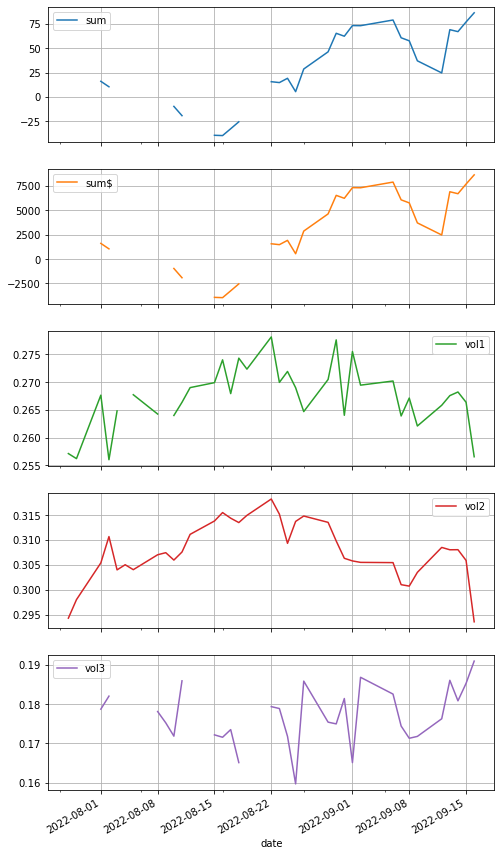

In [177]:

#SPY = Positions()  
#SPY.add_instrument(0,'SPY', date(2022,12,16), 'Put', 377, 10, 26.42, 8.84 )#entry 2022.08.10 check vols.add_instrument(1,'FVU2', date(2022,8,23), 'Call', 115.5, -14, 4.5,0.61 )
#SPY.add_instrument(1,'SPY', date(2022,12,16), 'Put', 340, -10, 31, 3.97) #entry 2022.08.10 chekc vols)
#SPY.add_instrument(2,'SPY', date(2022,12,16), 'Call', 458, -10, 18.27, 5.27)


secs = ['SPY US Equity','SPY US 12/16/22 P377 Equity',\
        'SPY US 12/16/22 P340 Equity',\
        'SPY US 12/16/22 C458 Equity']

positions = [10,-10,-10]
strikes = [377, 340, 458]
callput = ['Put','Put', 'Call']
spy = OptionTracker(dt.datetime(2022,7,28), dt.datetime(2022,12,16), secs, positions,strikes, callput)
data_spy = spy.create_time_series()

#graph_prices =  data[data['sum']*14*1000).plot()
data_spy[['sum', 'sum$', 'vol1', 'vol2', 'vol3']].plot(subplots = True, grid = True, figsize = (8,16))
data_spy.tail(10)

In [47]:
?black_scholes_put

In [66]:


a = black_scholes_put(393, 350, 0.25, 0.03, 0.26)
units = 4
delta = -0.37
print('prem '+ str(a*100*units))
print('size '+str(380*100*units))
print('delta '+str(delta*380*100*units))

b = black_scholes_put(393, 300, 0.25, 0.03, 0.36)
units = 4
delta = -0.06
print('prem '+ str(b*100*units))
print('size '+str(300*100*units))
print('delta '+str(delta*300*100*units))

prem 1759.9048326201228
size 152000
delta -56240.0
prem 653.8096318102034
size 120000
delta -7200.0


In [206]:
FV = Positions()  
FV.add_instrument(0,'FVU2', date(2022,8,23), 'Put',  112.5,14,5.5,0.71 ) #entry 2022.05.27
FV.add_instrument(1,'FVU2', date(2022,8,23), 'Call', 115.5, -14, 4.5,0.61 )
FV.add_instrument(2,'FVU2', date(2022,8,23), 'Call', 116.5, 14, 4.5, 0.42)
FV.add_instrument(3,'FVZ2', date(2022,11,23), 'Put', 112.25, 15, 5.5, 0.77 )
FV.add_instrument(4, 'FVZ2', date(2022,11,23), 'Call',  116, -15, 5.5,0.61) #entry 2022.08 early after Powell's pivot that wasn't. Added after NFP but too soon
FV.add_instrument(5,'FVZ2', date(2022,11,23), 'Call', 117, 15, 5.5, 0.42 )

FV._get_portfolio_()



{0: ('FVU2', datetime.date(2022, 8, 23), 'Put', 112.5, 14, 5.5, 0.71), 1: ('FVU2', datetime.date(2022, 8, 23), 'Call', 115.5, -14, 4.5, 0.61), 2: ('FVU2', datetime.date(2022, 8, 23), 'Call', 116.5, 14, 4.5, 0.42), 3: ('FVZ2', datetime.date(2022, 11, 23), 'Put', 112.25, 15, 5.5, 0.77), 4: ('FVZ2', datetime.date(2022, 11, 23), 'Call', 116, -15, 5.5, 0.61), 5: ('FVZ2', datetime.date(2022, 11, 23), 'Call', 117, 15, 5.5, 0.42)}
0.005989953234291923
0.0019731477687630725


,Inst,Call/Put,Strike,Size,Vol,Cost,Days,Spot,Distance%,Multiplier,Price,Delta,Price$,Delta$,MTM
Expiry,,,,,,,,,,,,,,,
2022-08-23,FVU2,Put,112.5,14,5.5,0.71,-27,109.359375,2.8,1000,0.000,0.000000,0.0,0.0,-9940.0
2022-08-23,FVU2,Call,115.5,-14,4.5,0.61,-27,109.359375,-5.5,1000,0.000,0.000000,-0.0,-0.0,8540.0
2022-08-23,FVU2,Call,116.5,14,4.5,0.42,-27,109.359375,-6.3,1000,0.000,0.000000,0.0,0.0,-5880.0
2022-11-23,FVZ2,Put,112.25,15,5.5,0.77,65,109.304688,2.7,1000,3.008,-0.860310,45120.0,-1448547.7,33570.0
2022-11-23,FVZ2,Call,116,-15,5.5,0.61,65,109.304688,-5.9,1000,0.005,0.005990,-75.0,-10422.5,9075.0
2022-11-23,FVZ2,Call,117,15,5.5,0.42,65,109.304688,-6.8,1000,0.001,0.001973,15.0,3462.9,-6285.0


<ipython-input-79-c500cffa4f2c>:14: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (log((S0 / K)) + (r + 0.5 * (v ** 2)) * T) / (v * sqrt(T))
<ipython-input-79-c500cffa4f2c>:15: RuntimeWarning: divide by zero encountered in double_scalars
  d2 = (log((S0 / K)) + (r - 0.5 * (v ** 2)) * T) / (v * sqrt(T))
<ipython-input-79-c500cffa4f2c>:22: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (log(S / K) + (r + 0.5 * v ** 2) * T) / (v * sqrt(T))
<ipython-input-79-c500cffa4f2c>:62: RuntimeWarning: divide by zero encountered in double_scalars
  implied_vol -= np.clip(diff/vega, -MAX_VOL_UPDATE, MAX_VOL_UPDATE)
<ipython-input-79-c500cffa4f2c>:5: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (log((S0 / K)) + (r + 0.5 * (v ** 2)) * T) / (v * sqrt(T))
<ipython-input-79-c500cffa4f2c>:6: RuntimeWarning: divide by zero encountered in double_scalars
  d2 = (log((S0 / K)) + (r - 0.5 * (v ** 2)) * T) / (v * sqrt(T))
<ipython-input-79-c500cffa

,FVU2 Comdty,FVU2P 112.5 Comdty,FVU2C 115.5 Comdty,FVU2C 116.5 Comdty,tau,vol1,vol2,vol3,sum,sum$,pnl_period
date,,,,,,,,,,,
2022-04-01,113.796875,NaN,NaN,NaN,0.375342,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-04,113.789062,0.890625,0.757812,0.492188,0.367123,0.064129,0.041247,0.043253,6.250000,6250.000,NaN
2022-04-05,113.125000,1.148438,0.523438,0.304688,0.364384,0.065656,0.041173,0.041908,9.296875,9296.875,3046.875
2022-04-06,113.125000,1.148438,0.523438,0.304688,0.361644,0.065813,0.041406,0.042130,9.296875,9296.875,0.000
2022-04-07,113.117188,1.171875,0.382812,0.171875,0.358904,0.066778,0.035585,0.034670,9.609375,9609.375,312.500
2022-04-08,112.828125,1.296875,0.320312,0.140625,0.356164,0.067517,0.036200,0.035342,11.171875,11171.875,1562.500
2022-04-11,112.710938,1.335938,0.289062,0.117188,0.347945,0.067712,0.036554,0.035123,11.640625,11640.625,468.750
2022-04-12,113.304688,1.085938,0.546875,0.351562,0.345205,0.066894,0.041516,0.044062,8.906250,8906.250,-2734.375
2022-04-13,113.406250,1.015625,0.578125,0.351562,0.342466,0.065643,0.041721,0.043179,7.890625,7890.625,-1015.625


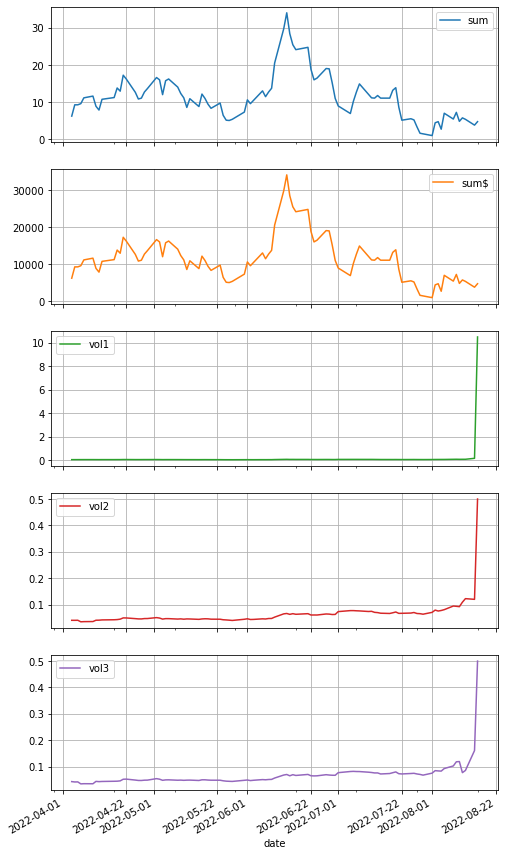

In [208]:
secs = ['FVU2 Comdty','FVU2P 112.5 Comdty','FVU2C 115.5 Comdty','FVU2C 116.5 Comdty']
positions = [10,-10,10]
strikes = [112.5, 115.5, 116.5]
callput = ['Put', 'Call','Call']
fvu = OptionTracker(dt.datetime(2022,4,1), dt.datetime(2022,8,16), secs, positions,strikes, callput)
data_fvu = fvu.create_time_series()

#graph_prices =  data[data['sum']*14*1000).plot()
data_fvu[['sum', 'sum$' ,'vol1', 'vol2', 'vol3']].plot(subplots = True, grid = True, figsize = (8,16))
data_fvu

,FVZ2 Comdty,FVZ2P 112.25 Comdty,FVZ2C 116 Comdty,FVZ2C 117 Comdty,tau,vol1,vol2,vol3,sum,sum$,pnl_period
date,,,,,,,,,,,
2022-09-12,110.140625,2.414062,0.039062,0.023438,0.205479,0.071867,0.057567,0.060734,35.976562,35976.5625,-351.5625
2022-09-13,109.492188,2.953125,0.023438,0.023438,0.202740,0.077189,0.058787,0.066625,44.296875,44296.8750,8320.3125
2022-09-14,109.445312,2.968750,0.023438,0.015625,0.200000,0.076323,0.059640,0.063713,44.414062,44414.0625,117.1875
2022-09-15,109.078125,3.312500,0.023438,0.015625,0.197260,0.081162,0.063261,0.067172,49.570312,49570.3125,5156.2500
2022-09-16,109.304688,3.101562,0.023438,0.015625,0.194521,0.078690,0.061796,0.065847,46.406250,46406.2500,-3164.0625


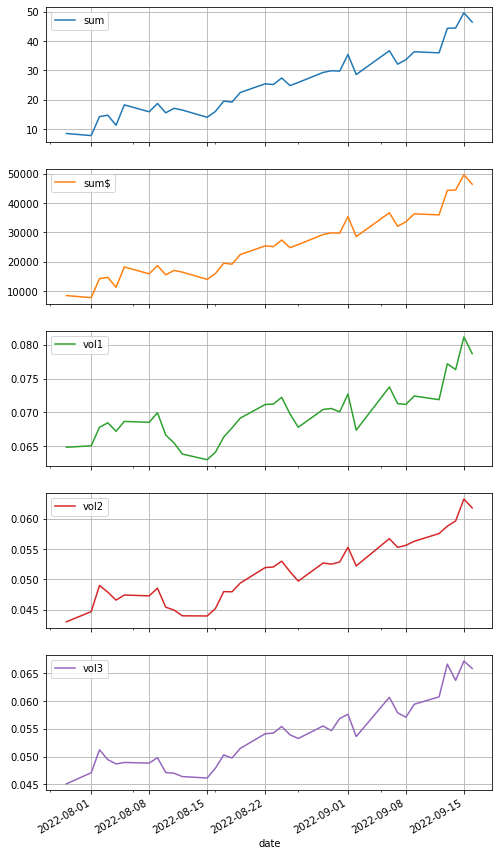

In [178]:
secs = ['FVZ2 Comdty','FVZ2P 112.25 Comdty','FVZ2C 116 Comdty','FVZ2C 117 Comdty']
positions = [15,-15,15]
strikes = [112.25, 116, 117]
callput = ['Put','Call','Call']


fvz = OptionTracker(dt.datetime(2022,7,29), dt.datetime(2022,11,26), secs, positions,strikes, callput)
data_fvz = fvz.create_time_series()

data_fvz[['sum', 'sum$','vol1', 'vol2', 'vol3']].plot(subplots = True, grid = True, figsize = (8,16))
data_fvz.tail()

In [179]:
data_esz.tail()

,ES1 Index,ESZ2P 3500 Index,ESZ2P 3000 Index,ESZ2C 4550 Index,tau,vol1,vol2,vol3,sum,sum$,pnl_period
date,,,,,,,,,,,
2022-09-12,4130.00,37.50,12.00,30.75,0.260274,0.297444,0.373217,0.175381,-52.5,-2625.0,-5750.0
2022-09-13,3950.25,63.25,19.50,12.75,0.257534,0.297842,0.371570,0.184173,310.0,15500.0,18125.0
2022-09-14,3965.50,59.00,17.75,12.75,0.254795,0.296369,0.369396,0.181111,285.0,14250.0,-1250.0
2022-09-15,3919.25,64.75,19.00,9.50,0.252055,0.292843,0.365440,0.182358,362.5,18125.0,3875.0
2022-09-16,3890.00,67.75,18.50,8.25,0.249315,0.289314,0.357670,0.185521,410.0,20500.0,2375.0


In [39]:
data_esu.tail()

,ESU2 Index,ESU2P 4000 Index,ESU2P 3500 Index,ESU2C 5200 Index,tau,vol1,vol2,vol3,sum,sum$,pnl_period
date,,,,,,,,,,,
2022-09-02,3924.50,110.0,3.50,0.05,0.038356,0.218823,0.328901,0.435007,525.40,26270.0,5965.0
2022-09-06,3910.50,114.5,2.55,0.05,0.027397,0.234379,0.358113,0.521208,554.55,27727.5,1457.5
2022-09-07,3980.00,65.0,1.10,0.05,0.024658,0.222192,0.374929,0.517581,317.20,15860.0,-11867.5
2022-09-08,4005.50,46.0,0.55,0.05,0.021918,0.209614,0.378943,0.536784,226.05,11302.5,-4557.5
2022-09-09,4067.25,19.5,0.40,0.05,0.019178,0.206157,0.428643,0.542404,94.60,4730.0,-6572.5


In [32]:
black_scholes_put(4059, 3000, 0.3068, 0.025, 0.37)

20.209130427360492

In [2]:
?FXOption

In [3]:
opt_put = FXOption(CallPutFlag = 'Call', K = 0.7920, dateEnd = date(2022,8,27), 
                notional = 1000000, 
                premConvention = "")

S = 0.7633
sigma  = 0.080995
rFor = 0.0183
rDom = 0.012866

print('value: '+'{:,}'.format(opt_put.price(S , sigma , rFor, rDom)))
print('delta: '+'{:,}'.format(opt_put.delta( S  , sigma , rFor, rDom, convention = 'SIF' )))
print('gamma: '+'{:,}'.format(opt_put.gamma(S, sigma , rFor, rDom, convention = 'SEF' )))

value: 496.0577543553599
delta: 51,592.439832804135
gamma: 46,662.40798509485
